In [1]:
%load_ext jupyter_black

# Libraries
import json
import csv
import pandas as pd
import os
import re

import requests
from PIL import Image

from transformers import AutoModelForCausalLM, AutoProcessor, GenerationConfig
import torch

from tqdm.notebook import tqdm

# for showing image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

%matplotlib inline

In [2]:
# load model
model_id = "allenai/Molmo-7B-D-0924"
processor = AutoProcessor.from_pretrained(
    "allenai/Molmo-7B-D-0924",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model = AutoModelForCausalLM.from_pretrained(
    "allenai/Molmo-7B-D-0924",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

# parameters to model
prompt = "You are a program designed to help blind and low-vision users understand images. When asked about the image, generate accessible image description that includes key visual and contextual details of the image for blind and low-vision people. Focus on the following principles: Clarity and Conciseness: Use simple, straightforward language to describe the main subjects and their relationships.; Relevance: Highlight only essential visual elements that contribute to understanding the image or its purpose.; Context: Provide contextual information when necessary, such as emotional tone, setting, or action. Avoid assumptions or subjective interpretations.; Specificity: Include important details like colors, shapes, textures, or text visible in the image, if relevant. Avoid overly general terms or unnecessary details. Once you generate your caption, shorten it to a succinct, single sentence. Output only the final sentence. Can you please tell me what is in this image?"


# captioning function
def generate_caption(
    image_object, model, processor, prompt, temperature=1.0, do_sample=False
):
    """
    Generates a caption for an image.

    Inputs:
    - image_object (pil Image): image to caption.
    - model (torch model): loaded model to use for captioning.
    - processor (torch processor): loaded processor for pre-processing inputs.
    - temperature (float; optional): temperature setting for model, greater than 0. Defaults to 1.0; lower values are more deterministic.
    - do_sample (boolean; optional): whether model should sample probabilities. Defaults to False -- greedy decoding.

    Output:
    - (str): caption for image.
    """
    # process the image and text
    inputs = processor.process(
        images=[image_object],
        text=prompt,
    )

    # move inputs to the correct device and make a batch of size 1
    inputs = {k: v.to(model.device).unsqueeze(0) for k, v in inputs.items()}

    # generate output; maximum 200 new tokens; stop generation when <|endoftext|> is generated
    output = ""
    with torch.autocast(device_type="mps", enabled=True, dtype=torch.bfloat16):
        output = model.generate_from_batch(
            inputs,
            GenerationConfig(max_new_tokens=200, stop_strings="<|endoftext|>"),
            tokenizer=processor.tokenizer,
            use_cache=False,
            temperature=temperature,
            do_sample=do_sample,
        )

        # only get generated tokens; decode them to text
        generated_tokens = output[0, inputs["input_ids"].size(1) :]
        generated_text = processor.tokenizer.decode(
            generated_tokens, skip_special_tokens=True
        )
        output = generated_text.strip()
    return output

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [3]:
# set target dataset and file locations
target_caption_dataset_filename = "../data/caption-dataset/annotations/train.json"
image_folder = "../data/clean-images"
filenames = next(os.walk(image_folder), (None, None, []))[2]

# get image quality annotations
target_image_quality_dataset_filename = (
    "../data/image-quality-assessment/annotations/train.json"
)

In [4]:
# get images and annotations in one dataframe
image_annotation_df = None
with open(target_caption_dataset_filename) as f:
    # load caption dataset
    caption_dataset_json = json.load(f)

    # combine image files and annotations
    images_df = pd.DataFrame.from_dict(caption_dataset_json["images"])
    annotations_df = pd.DataFrame.from_dict(caption_dataset_json["annotations"])
    grouped_annotations = (
        annotations_df.groupby(["image_id"]).agg(tuple).map(list).reset_index()
    )
    image_annotation_df = images_df.merge(
        grouped_annotations[["image_id", "caption", "is_precanned", "is_rejected"]],
        left_on="id",
        right_on="image_id",
    )

    # vizwiz_url is broken, so fix with https://vizwiz.cs.colorado.edu/*
    image_annotation_df["vizwiz_url"] = image_annotation_df["vizwiz_url"].apply(
        lambda x: x.replace(
            "https://ivc.ischool.utexas.edu/", "https://vizwiz.cs.colorado.edu/"
        )
    )


image_annotation_df

,file_name,vizwiz_url,id,text_detected,image_id,caption,is_precanned,is_rejected
0,VizWiz_train_00000000.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,0,True,0,[ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS ...,"[False, False, True, False, False]","[False, False, True, False, False]"
1,VizWiz_train_00000001.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,1,True,1,[A can of Coca Cola on a counter is shown for ...,"[False, False, False, False, False]","[False, False, False, False, False]"
2,VizWiz_train_00000002.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,2,True,2,[A can of crushed tomatoes are on a brown surf...,"[False, False, False, False, False]","[False, False, False, False, False]"
3,VizWiz_train_00000003.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,3,True,3,[A white screen with a captcha that needs to b...,"[False, False, False, False, False]","[False, False, False, False, False]"
4,VizWiz_train_00000004.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,4,True,4,[A box for a garden light rests in someone's l...,"[False, False, False, False, False]","[False, False, False, False, False]"
...,...,...,...,...,...,...,...,...
23426,VizWiz_train_00023426.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23426,True,23426,[A PlayStation 2 video game that is for the sp...,"[False, False, False, False, False]","[False, False, False, False, False]"
23427,VizWiz_train_00023427.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23427,False,23427,[A folded paper currency with a depiction of a...,"[False, True, False, False, True]","[False, False, False, False, False]"
23428,VizWiz_train_00023428.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23428,True,23428,[A black and white sheet of paper with font le...,"[False, False, False, False, False]","[False, False, False, False, False]"
23429,VizWiz_train_00023429.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23429,True,23429,[A bottle of Healthy Hair Skin & Nails capsule...,"[False, False, False, False, False]","[False, False, False, False, False]"


In [5]:
# get image quality
image_quality_annotation_df = None
with open(target_image_quality_dataset_filename) as f:
    # load image quality annotation dataset
    image_quality_dataset_json = json.load(f)
    image_quality_df = pd.DataFrame.from_dict(image_quality_dataset_json)

    # expand object of flaws into individual columns and rename
    image_quality_df = pd.concat(
        [
            image_quality_df.drop(["flaws"], axis=1),
            pd.json_normalize(image_quality_df["flaws"]),
        ],
        axis=1,
    )
    image_quality_df.rename(
        columns={
            "FRM": "framing",
            "BLR": "blur",
            "DRK": "too dark",
            "BRT": "too bright",
            "OBS": "obstruction",
            "OTH": "other",
            "NON": "no issue",
            "ROT": "rotation",
        },
        inplace=True,
    )

image_quality_df

,image,unrecognizable,framing,blur,too dark,too bright,obstruction,other,no issue,rotation
0,VizWiz_train_00022585.jpg,4,1,5,0,3,0,0,0,0
1,VizWiz_train_00004143.jpg,1,4,3,0,0,0,0,1,0
2,VizWiz_train_00002092.jpg,5,0,3,2,0,1,2,0,0
3,VizWiz_train_00008936.jpg,1,4,4,0,0,1,0,0,0
4,VizWiz_train_00020927.jpg,0,0,2,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...
23426,VizWiz_train_00020740.jpg,2,3,3,1,1,1,0,1,0
23427,VizWiz_train_00014487.jpg,0,0,1,0,0,0,0,1,4
23428,VizWiz_train_00005846.jpg,1,4,0,2,0,0,0,1,0
23429,VizWiz_train_00017677.jpg,0,3,1,0,0,0,1,1,0


In [6]:
# combine image and quality datasets together
image_captioning_input = image_annotation_df.merge(
    image_quality_df, left_on="file_name", right_on="image"
).drop(["image"], axis=1)

In [7]:
# filter input for only the selected clean images
filtered_images_df = image_captioning_input.query("file_name.isin(@filenames)")
filtered_images_df["model_caption"] = ""
dataset_to_caption = filtered_images_df.to_dict("records")

filtered_images_df

/var/folders/6w/gkg9vw3d29jglv9knrxxf3r40000gn/T/ipykernel_11950/826547608.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_images_df["model_caption"] = ""


,file_name,vizwiz_url,id,text_detected,image_id,caption,is_precanned,is_rejected,unrecognizable,framing,blur,too dark,too bright,obstruction,other,no issue,rotation,model_caption
0,VizWiz_train_00000000.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,0,True,0,[ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS ...,"[False, False, True, False, False]","[False, False, True, False, False]",1,3,1,0,0,0,1,1,0,
12,VizWiz_train_00000012.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,12,True,12,[a jvc DVD and vcr remote someone has in their...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,1,0,0,0,0,4,0,
40,VizWiz_train_00000040.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,40,True,40,[Bar code that appears to be off of a piece of...,"[False, False, False, False, False]","[False, False, False, False, False]",0,4,1,0,0,0,1,0,0,
43,VizWiz_train_00000043.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,43,True,43,[a container of apple pie spice containing gin...,"[False, False, False, False, False]","[False, False, False, False, False]",0,2,1,0,0,0,0,1,3,
44,VizWiz_train_00000044.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,44,True,44,[Heinz rice and chicken frozen TV dinner In a...,"[False, False, False, False, False]","[False, True, False, False, False]",0,3,1,0,0,0,0,1,1,
49,VizWiz_train_00000049.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,49,True,49,[A Kirkland water bottle is sitting on a count...,"[False, False, False, False, False]","[False, False, False, False, False]",0,1,1,0,0,0,0,3,1,
50,VizWiz_train_00000050.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,50,True,50,[A plastic container of a dairy product with t...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,1,0,0,0,0,4,0,
23146,VizWiz_train_00023146.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23146,True,23146,[A yellow hi-liter sitting on a marbled counte...,"[False, False, False, False, False]","[False, False, False, False, False]",0,1,0,0,0,0,0,4,0,
23326,VizWiz_train_00023326.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23326,False,23326,[A cat standing in the hallway with wooden flo...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,0,0,0,0,0,5,0,
23356,VizWiz_train_00023356.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,23356,False,23356,[An orange and a lemon sitting out on the coun...,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,0,0,0,0,0,5,0,


In [8]:
# label data
for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    image_file = os.path.join(image_folder, dataset_to_caption[index]["file_name"])
    image = Image.open(image_file)

    # generate caption and store for output
    dataset_to_caption[index]["model_caption"] = generate_caption(
        image, model, processor, prompt, temperature=1.0, do_sample=False
    )

  0%|          | 0/10 [00:00<?, ?it/s]

In [9]:
list(pd.DataFrame.from_dict(dataset_to_caption)["model_caption"])

['A clear plastic container with a green label showing basil leaves, sitting on a patterned tablecloth.',
 "A person's hand holds a JVC DVD and VCR remote control, with another hand resting on their leg in the background.",
 'The image shows a shipping label with a barcode, "Forwarder Air Bill" text, and handwritten letters "EQ" and "Scott" on a white background.',
 'The image shows a spice jar labeled "Apple Pie by Pure and Natural Spices" with a yellow oval label and a red banner containing the brand name.',
 'The image shows a box of Heinz sweet and sour chicken with a picture of the meal on a plate.',
 'A Kirkland Signature water bottle sits on a desk with a white paper, power strip, and other items nearby.',
 'A hand holds a Dr. Oetker Onken yogurt container in a kitchen with wooden floors and a white chair visible.',
 'A yellow highlighter with "Hi-Liter" written in black text on a gray speckled surface.',
 'A small black and brown cat with green eyes is walking on a wooden floor

## Testing Defocus Blur before captioning
[Defocus](https://albumentations.ai/docs/api_reference/augmentations/blur/transforms/#albumentations.augmentations.blur.transforms.Defocus) blur simulates out-of-focus cameras (which can happen if a BLV person is taking a picture) by applying both a disc kernal and Gaussian blur to the image. The blur is specified by 3 parameters:
- `radius (tuple[int, int], int)`: Range for the radius of the defocus blur. If a single int is provided, the range will be [1, radius]. Larger values create a stronger blur effect. **I use 10, 20, 30 to correspond to light, medium, and heavy blurring for now; this is set as [radius, radius] so the blurring is consistent. Heavy blurring does not make the image illegible to a human.**
- `alias_blur (tuple[float, float] | float)`: Range for the standard deviation of the Gaussian blur applied after the main defocus blur. This helps to reduce aliasing artifacts. If a single float is provided, the range will be (0, alias_blur). Larger values create a smoother, more aliased effect. **I fix this to (0.4, 0.4) so a consistent amount of blur is always applied.**
- `p (float)`: probability of applying transform. This is used in a data augmentation pipeline where one wants to try various combinations of transformations during training / evaluation. **Since we always want a blur, `p = 1.0` below**

The defocus effect is created using a disc kernel, which simulates the shape of a camera's aperture, with a larger `radius` causing a more noticable defocusing effect. The Gaussian blur specified by `alias_blur` helps to soften the edges of the disc kernel, creating a more natural-looking defocus effect.

In [10]:
import albumentations as A
import numpy as np


def pil_to_base64(pil_image):
    im_file = BytesIO()
    pil_image.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
    return base64.b64encode(im_bytes).decode("utf-8")

/Users/kgarg/.local/share/virtualenvs/local-blurred-captioning-exploration-4LZKhcfn/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


### Testing blur settings

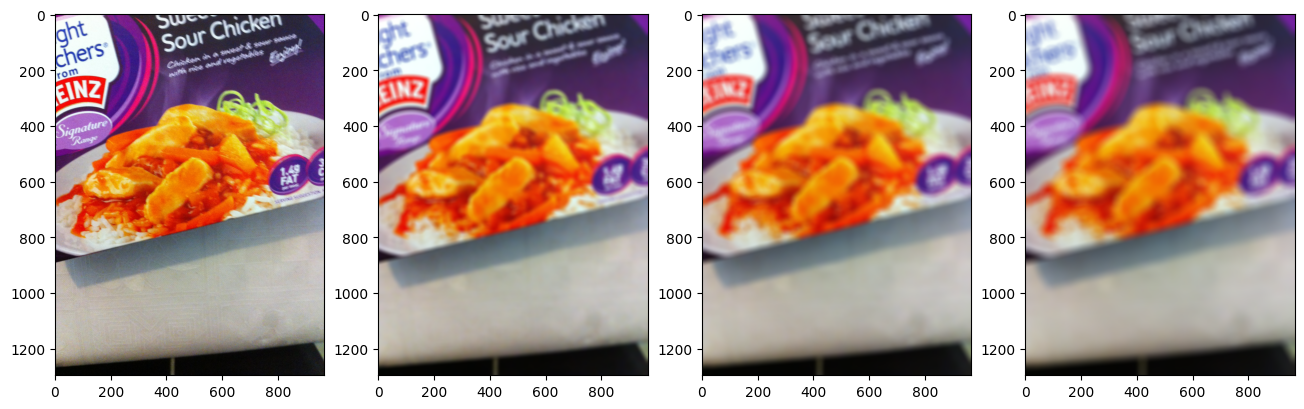

In [11]:
# set-up a plot to show the images
rcParams["figure.figsize"] = 16, 8
fig, ax = plt.subplots(1, 4)
plt_counter = 0

# show original image
pillow_image = Image.open(
    os.path.join(image_folder, dataset_to_caption[4]["file_name"])
)
ax[plt_counter].imshow(pillow_image)
plt_counter += 1

# apply varying levels of defocus
disc_blur_settings = [10, 15, 20]
image_np = np.array(pillow_image)
for setting in disc_blur_settings:
    blur_transform = A.Compose(
        [A.Defocus(radius=(setting, setting), alias_blur=(0.6, 0.6), p=1.0)], p=1.0
    )
    blurred_image_np = blur_transform(image=image_np)["image"]
    blurred_image_pil = Image.fromarray(np.uint8(blurred_image_np)).convert("RGB")
    ax[plt_counter].imshow(blurred_image_pil)
    plt_counter += 1

In [12]:
# add placeholder for blurred captions
for item in dataset_to_caption:
    item["low_blur_model_caption"] = ""
    item["med_blur_model_caption"] = ""
    item["high_blur_model_caption"] = ""

In [13]:
for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    image_file = os.path.join(image_folder, dataset_to_caption[index]["file_name"])

    # generate output for each blur
    # show original image
    pillow_image = Image.open(image_file)

    # apply varying levels of defocus
    disc_blur_settings = [
        ("low_blur_model_caption", 10),
        ("med_blur_model_caption", 15),
        ("high_blur_model_caption", 20),
    ]
    image_np = np.array(pillow_image)
    for key, setting in disc_blur_settings:
        blur_transform = A.Compose(
            [A.Defocus(radius=(setting, setting), alias_blur=(0.6, 0.6), p=1.0)], p=1.0
        )
        blurred_image_np = blur_transform(image=image_np)["image"]
        blurred_image_pil = Image.fromarray(np.uint8(blurred_image_np)).convert("RGB")

        # generate caption and store for output
        dataset_to_caption[index][key] = generate_caption(
            blurred_image_pil,
            model,
            processor,
            prompt,
            temperature=1.0,
            do_sample=False,
        )

  0%|          | 0/10 [00:00<?, ?it/s]

In [14]:
# expand human captions into separate columns
output_dataset = json.loads(json.dumps(dataset_to_caption))
for index, item in enumerate(output_dataset):
    if type(item["caption"]) == str:
        item["caption"] = [
            x.strip()
            for x in re.split(
                r'(["\'])(.*?)\1', item["caption"].replace("[", "").replace("]", "")
            )
            if x.strip() != ""
            and x.strip() != ","
            and x.strip() != "'"
            and x.strip() != '"'
        ]
    output_dataset[index]["human_caption_1"] = item["caption"][0]
    output_dataset[index]["human_caption_2"] = item["caption"][1]
    output_dataset[index]["human_caption_3"] = item["caption"][2]
    output_dataset[index]["human_caption_4"] = item["caption"][3]
    output_dataset[index]["human_caption_5"] = item["caption"][4]
    del output_dataset[index]["caption"]

In [16]:
# move model captions to end of data frame
output_df = pd.DataFrame.from_dict(output_dataset)
for col in [
    "model_caption",
    "low_blur_model_caption",
    "med_blur_model_caption",
    "high_blur_model_caption",
]:
    output_df.insert(len(output_df.columns) - 1, col, output_df.pop(col))
output_df.insert(0, "id", output_df.pop("id"))

# add a note column
output_df["notes (include initials, e.g. 'KG: ...')"] = ""

# rename columns
output_df.rename(columns={"id": "vizwiz_id"}, inplace=True)

# save file
output_df.to_csv(
    "../data/labeled-data/molmo-model/blurred-image-experiment_03-03-25.csv",
    index=False,
)

# print dataframe
output_df.head()

,vizwiz_id,file_name,vizwiz_url,text_detected,image_id,is_precanned,is_rejected,unrecognizable,framing,blur,...,human_caption_1,human_caption_2,human_caption_3,human_caption_4,human_caption_5,model_caption,low_blur_model_caption,med_blur_model_caption,high_blur_model_caption,"notes (include initials, e.g. 'KG: ...')"
0,0,VizWiz_train_00000000.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,0,"[False, False, True, False, False]","[False, False, True, False, False]",1,3,1,...,ITS IS A BASIL LEAVES CONTAINER ITS CONTAINS T...,A green and white plastic condiment bottle con...,Quality issues are too severe to recognize vis...,A bottle of spices in a plastic container layi...,some basil leaves in a container on a counter,A clear plastic container with a green label s...,A small plastic container of dried basil leave...,A clear plastic container with a green label r...,A blurry image of a spice jar with a green lab...,
1,12,VizWiz_train_00000012.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,12,"[False, False, False, False, False]","[False, False, False, False, False]",0,0,1,...,a jvc DVD and vcr remote someone has in their ...,A JVC Remote Control for a DVD and VCR.,A gray remote has many buttons on it,PERSON HOLDING A TV REMOTE IN THEIR HAND,A JVC branded remote in a white hand,A person's hand holds a JVC DVD and VCR remote...,A person's hand holds a white JVC remote contr...,A person's hand holds a white remote control w...,"A person's hands holding a remote control, wit...",
2,40,VizWiz_train_00000040.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,40,"[False, False, False, False, False]","[False, False, False, False, False]",0,4,1,...,Bar code that appears to be off of a piece of ...,barcode on a shipping label with blue ink star,An airmail envelope with a bar code on it.,The blue mark is on the label by the bar code.,Partial image of an air bill used for shipping,The image shows a shipping label with a barcod...,The image shows a forwarder airbill with a bar...,The image shows a shipping label with a barcod...,The image shows a blurry barcode on a white la...,
3,43,VizWiz_train_00000043.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,43,"[False, False, False, False, False]","[False, False, False, False, False]",0,2,1,...,a container of apple pie spice containing ging...,Label on container for natural apple pie spice,A plastic container that contains apple pie sp...,"A jar of ""Apple Pie Spice"" comprised of a zest...",A container / package that contains various go...,"The image shows a spice jar labeled ""Apple Pie...",The image shows a package of apple pie spice f...,The image shows a package of Marston's Extra A...,The image shows a package of Halls Apple Pie S...,
4,44,VizWiz_train_00000044.jpg,https://vizwiz.cs.colorado.edu/VizWiz_visualiz...,True,44,"[False, False, False, False, False]","[False, True, False, False, False]",0,3,1,...,Heinz rice and chicken frozen TV dinner In a ...,Beautiful view from behind the walls hidden un...,a box of Weight Watchers brand sweet and sour ...,A Weight Watchers boxed dinner of Sweet & Sour...,A ready to microwave meal of Sweet and sour ch...,The image shows a box of Heinz sweet and sour ...,The image shows a box of Heinz sweet and sour ...,This image shows a TV dinner box for a sour ch...,The image shows a box of Kraft macaroni and ch...,


## Testing Privacy Modifications On Image Labeling
VizWiz has a privacy dataset where private portions of images are obscured with a single color representing the mean-color of the dataset, or some of the selected private content overlaid on it; see the [Visual Privacy Challenge](https://vizwiz.org/tasks-and-datasets/vizwiz-priv/). The output dataframe will have 2 images captioned:
1. `mean_image` is the private content obscured with the mean color.
2. `filled_image` is the private content obscured with the image content.

The following example groups are selected:
1. Food: images of food, like cans / bottles of soda and granola boxes. Note that the private content is **not** the food itself, but something else in the image.
2. Login screens: screens asking for login information.
3. Mail / credit cards: pictures that have the image taker's address or credit card information.
4. Medicine: pill bottles that obsecure patient information.
5. People: images with people. Some include background scenes that might be useful to label (e.g., a church).

Due to the private nature of some images (e.g., credit cards), clean images are not available for most examples selected below.

In [18]:
# load images
mean_fill_image_folder = "../data/privacy-images/mean-pixel"
image_fill_image_folder = "../data/privacy-images/image-fill"
input_dict = {}

for subdir in next(os.walk(mean_fill_image_folder), ([], [], []))[1]:
    filename = next(os.walk(mean_fill_image_folder + "/" + subdir), ([], [], []))[2]

    for file in filename:
        name_without_extension, _ = os.path.splitext(file)
        input_dict[name_without_extension] = {
            "image_type": subdir,
            "mean_fill_filepath": mean_fill_image_folder + "/" + subdir + "/" + file,
            "image_fill_filepath": "",
            "mean_fill_caption": "",
            "image_fill_caption": "",
            "notes (include initials, e.g. 'KG: ...')": "",
        }

for subdir in next(os.walk(image_fill_image_folder), ([], [], []))[1]:
    filename = next(os.walk(image_fill_image_folder + "/" + subdir), ([], [], []))[2]

    for file in filename:
        name_without_extension, _ = os.path.splitext(file)
        if name_without_extension in input_dict:
            input_dict[name_without_extension]["image_fill_filepath"] = (
                image_fill_image_folder + "/" + subdir + "/" + file
            )
            input_dict[name_without_extension]["image_fill_caption"] = ""

dataset_to_caption = [{"name": key} | value for key, value in input_dict.items()]
pd.DataFrame.from_dict(dataset_to_caption)

,name,image_type,mean_fill_filepath,image_fill_filepath,mean_fill_caption,image_fill_caption,"notes (include initials, e.g. 'KG: ...')"
0,VizWiz_v2_000000044745,mail-credit-cards,../data/privacy-images/mean-pixel/mail-credit-...,../data/privacy-images/image-fill/mail-credit-...,,,
1,VizWiz_v2_000000044793,mail-credit-cards,../data/privacy-images/mean-pixel/mail-credit-...,../data/privacy-images/image-fill/mail-credit-...,,,
2,VizWiz_v2_000000031337,mail-credit-cards,../data/privacy-images/mean-pixel/mail-credit-...,../data/privacy-images/image-fill/mail-credit-...,,,
3,VizWiz_v2_000000031271,mail-credit-cards,../data/privacy-images/mean-pixel/mail-credit-...,../data/privacy-images/image-fill/mail-credit-...,,,
4,VizWiz_v2_000000031315,mail-credit-cards,../data/privacy-images/mean-pixel/mail-credit-...,../data/privacy-images/image-fill/mail-credit-...,,,
5,VizWiz_v2_000000044775,mail-credit-cards,../data/privacy-images/mean-pixel/mail-credit-...,../data/privacy-images/image-fill/mail-credit-...,,,
6,VizWiz_v2_000000031292,medicine,../data/privacy-images/mean-pixel/medicine/Viz...,../data/privacy-images/image-fill/medicine/Viz...,,,
7,VizWiz_v2_000000041554,medicine,../data/privacy-images/mean-pixel/medicine/Viz...,../data/privacy-images/image-fill/medicine/Viz...,,,
8,VizWiz_v2_000000044779,people,../data/privacy-images/mean-pixel/people/VizWi...,../data/privacy-images/image-fill/people/VizWi...,,,
9,VizWiz_v2_000000044797,people,../data/privacy-images/mean-pixel/people/VizWi...,../data/privacy-images/image-fill/people/VizWi...,,,


In [19]:
for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    mean_fill_image_file = row["mean_fill_filepath"]
    image_fill_image_file = row["image_fill_filepath"]

    # load each image
    mean_fill_pillow_image = Image.open(mean_fill_image_file)
    image_fill_pillow_image = Image.open(image_fill_image_file)

    # generate output for mean fill image and store in dict
    dataset_to_caption[index]["mean_fill_caption"] = generate_caption(
        mean_fill_pillow_image,
        model,
        processor,
        prompt,
        temperature=1.0,
        do_sample=False,
    )

    # generate output for image fill image and store in dict
    dataset_to_caption[index]["image_fill_caption"] = generate_caption(
        image_fill_pillow_image,
        model,
        processor,
        prompt,
        temperature=1.0,
        do_sample=False,
    )

  0%|          | 0/16 [00:00<?, ?it/s]

In [20]:
# create a dataframe
output_df = pd.DataFrame.from_dict(dataset_to_caption)

# sort on image type and name
output_df.sort_values(by=["image_type", "name"], inplace=True)

# save file
output_df.to_csv(
    "../data/labeled-data/molmo-model/privacy-image-experiment_03-03-25.csv",
    index=False,
)

# print dataframe
output_df.head()

,name,image_type,mean_fill_filepath,image_fill_filepath,mean_fill_caption,image_fill_caption,"notes (include initials, e.g. 'KG: ...')"
12,VizWiz_v2_000000031196,food,../data/privacy-images/mean-pixel/food/VizWiz_...,../data/privacy-images/image-fill/food/VizWiz_...,The image shows a box of Nature Valley granola...,The image shows a box of Nature Valley granola...,
11,VizWiz_v2_000000031219,food,../data/privacy-images/mean-pixel/food/VizWiz_...,../data/privacy-images/image-fill/food/VizWiz_...,A green Mountain Dew bottle sits on a desk wit...,"A Mountain Dew bottle, a phone, and some paper...",
14,VizWiz_v2_000000031177,login-screens,../data/privacy-images/mean-pixel/login-screen...,../data/privacy-images/image-fill/login-screen...,The image shows a Windows 7 setup screen with ...,The image shows a Windows 7 setup screen with ...,
13,VizWiz_v2_000000037280,login-screens,../data/privacy-images/mean-pixel/login-screen...,../data/privacy-images/image-fill/login-screen...,A MacBook Air laptop screen showing a GoDaddy ...,A MacBook Air laptop screen showing a GoDaddy ...,
15,VizWiz_v2_000000041592,login-screens,../data/privacy-images/mean-pixel/login-screen...,../data/privacy-images/image-fill/login-screen...,The image shows a login page with fields for u...,The image shows a login page with fields for u...,


## Testing Obscured Images
Images taken by BLV people may have parts obscured by hands or other objects, or be mis-framed. This part of the notebook examines the effects of these obscurations on image captioning.

In [21]:
# load images
clean_image_folder = "../data/obscured-images/clean-images"
cropped_image_folder = "../data/obscured-images/cropped-images"
obscured_image_folder = "../data/obscured-images/obscured-images"
input_dict = {}

# for subdir in next(os.walk(clean_image_folder), ([], [], []))[1]:
#     print(subdir)
#     filename = next(os.walk(clean_image_folder + "/" + subdir), ([], [], []))[2]

for file in next(os.walk(clean_image_folder), ([], [], []))[2]:
    name_without_extension, _ = os.path.splitext(file)
    input_dict[name_without_extension] = {
        "clean_image_filepath": clean_image_folder + "/" + file,
        "cropped_image_filepath": "",
        "obscured_image_filepath": "",
        "clean_image_caption": "",
        "cropped_image_caption": "",
        "obscured_image_caption": "",
        "notes (include initials, e.g. 'KG: ...')": "",
    }

for file in next(os.walk(cropped_image_folder), ([], [], []))[2]:
    name_without_extension, _ = os.path.splitext(file)
    if name_without_extension in input_dict:
        input_dict[name_without_extension]["cropped_image_filepath"] = (
            cropped_image_folder + "/" + file
        )

for file in next(os.walk(obscured_image_folder), ([], [], []))[2]:
    name_without_extension, _ = os.path.splitext(file)
    if name_without_extension in input_dict:
        input_dict[name_without_extension]["obscured_image_filepath"] = (
            obscured_image_folder + "/" + file
        )

dataset_to_caption = [{"name": key} | value for key, value in input_dict.items()]
pd.DataFrame.from_dict(dataset_to_caption)

,name,clean_image_filepath,cropped_image_filepath,obscured_image_filepath,clean_image_caption,cropped_image_caption,obscured_image_caption,"notes (include initials, e.g. 'KG: ...')"
0,VizWiz_test_00000565,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,,,,
1,VizWiz_test_00000004,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,,,,
2,VizWiz_test_00000079,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,,,,
3,VizWiz_test_00000235,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,,,,
4,VizWiz_test_00000025,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,,,,
5,VizWiz_test_00000032,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,,,,


In [22]:
for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image for current annotation
    clean_image_file = row["clean_image_filepath"]
    cropped_image_file = row["cropped_image_filepath"]
    obscured_image_file = row["obscured_image_filepath"]

    # load each image
    clean_pillow_image = Image.open(clean_image_file)
    cropped_pillow_image = Image.open(cropped_image_file)
    obscured_pillow_image = Image.open(obscured_image_file)

    # generate output for clean image and store in dict
    dataset_to_caption[index]["clean_image_caption"] = generate_caption(
        clean_pillow_image,
        model,
        processor,
        prompt,
        temperature=1.0,
        do_sample=False,
    )

    # generate output for cropped image and store in dict
    dataset_to_caption[index]["cropped_image_caption"] = generate_caption(
        cropped_pillow_image,
        model,
        processor,
        prompt,
        temperature=1.0,
        do_sample=False,
    )

    # generate output for obscured image and store in dict
    dataset_to_caption[index]["obscured_image_caption"] = generate_caption(
        obscured_pillow_image,
        model,
        processor,
        prompt,
        temperature=1.0,
        do_sample=False,
    )

  0%|          | 0/6 [00:00<?, ?it/s]

In [23]:
# create a dataframe
output_df = pd.DataFrame.from_dict(dataset_to_caption)

# sort on image type and name
output_df.sort_values(by=["name"], inplace=True)

# save file
output_df.to_csv(
    "../data/labeled-data/molmo-model/obscured-image-experiment_03-03-25.csv",
    index=False,
)

# print dataframe
output_df.head()

,name,clean_image_filepath,cropped_image_filepath,obscured_image_filepath,clean_image_caption,cropped_image_caption,obscured_image_caption,"notes (include initials, e.g. 'KG: ...')"
1,VizWiz_test_00000004,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,A carton of Sealtest half and half cream sits ...,A half-and-half carton sits on a kitchen count...,A carton of Sealtest half and half cream on a ...,
4,VizWiz_test_00000025,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,A hand holds a green bottle with white pills a...,A green bottle with a white cap and a trash ca...,A green bottle with a white cap and white labe...,
5,VizWiz_test_00000032,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,"The image shows a book cover for ""Queen of Sor...","The image shows a book cover for ""Queen Sorcer...","The image shows a book cover for ""Queen of Sor...",
2,VizWiz_test_00000079,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,A hand holds a can of organic black beans on a...,A hand holds a can of organic black beans agai...,A can of organic black beans with a beige labe...,
3,VizWiz_test_00000235,../data/obscured-images/clean-images/VizWiz_te...,../data/obscured-images/cropped-images/VizWiz_...,../data/obscured-images/obscured-images/VizWiz...,A person's hand holds a white spray bottle lab...,A person's arm holds a white spray bottle with...,A white spray bottle with a blue nozzle is sho...,


## Testing Rotated Images
Images taken by BLV people may not be oriented in expected ways. For example, a bottle of condiments could be held upside down. We hypothesize that this can cause issues with VLMs since their training data is likely on well-framed and oriented images. Below, we analyze 3 cases:
1. Little text images, such as text labels on a remote
2. Medium text images, such as a can of food or a bag of chips
3. Heavy text images, such as a nutritional label.
The hypothesis is that heavier text images are more likely to be affected by rotations when captioning.

Two types of rotation are applied:
1. 90 degree rotation, which corresponds to an image taken vertically when intended to be taken horizontally
2. 180 degree rotation, which corresponds to the object in an image being flipped

In [24]:
import albumentations as A
import numpy as np


def pil_to_base64(pil_image):
    im_file = BytesIO()
    pil_image.save(im_file, format="JPEG")
    im_bytes = im_file.getvalue()  # im_bytes: image in binary format.
    return base64.b64encode(im_bytes).decode("utf-8")

In [25]:
# load images
light_text_image_folder = "../data/rotation-experiment-images/light-text-images"
medium_text_image_folder = "../data/rotation-experiment-images/medium-text-images"
heavy_text_image_folder = "../data/rotation-experiment-images/heavy-text-images"
input_dict = {}

all_files = [
    next(os.walk(light_text_image_folder), ([], [], [])),
    next(os.walk(medium_text_image_folder), ([], [], [])),
    next(os.walk(heavy_text_image_folder), ([], [], [])),
]

for directory in all_files:
    image_type = (
        directory[0].split("./data/rotation-experiment-images/")[1].replace("-", " ")
    )
    for file in directory[2]:
        name_without_extension, _ = os.path.splitext(file)
        input_dict[name_without_extension] = {
            "type": image_type,
            "image_filepath": directory[0] + "/" + file,
            "original_image_caption": "",
            "rotation_90_image_caption": "",
            "rotation_180_image_caption": "",
            "notes (include initials, e.g. 'KG: ...')": "",
        }

dataset_to_caption = [{"name": key} | value for key, value in input_dict.items()]
pd.DataFrame.from_dict(dataset_to_caption)

,name,type,image_filepath,original_image_caption,rotation_90_image_caption,rotation_180_image_caption,"notes (include initials, e.g. 'KG: ...')"
0,VizWiz_train_00000267,light text images,../data/rotation-experiment-images/light-text-...,,,,
1,VizWiz_train_00000012,light text images,../data/rotation-experiment-images/light-text-...,,,,
2,VizWiz_train_00000417,light text images,../data/rotation-experiment-images/light-text-...,,,,
3,VizWiz_train_00000124,light text images,../data/rotation-experiment-images/light-text-...,,,,
4,VizWiz_train_00000111,medium text images,../data/rotation-experiment-images/medium-text...,,,,
5,VizWiz_train_00000006,medium text images,../data/rotation-experiment-images/medium-text...,,,,
6,VizWiz_train_00000171,medium text images,../data/rotation-experiment-images/medium-text...,,,,
7,VizWiz_train_00000252,medium text images,../data/rotation-experiment-images/medium-text...,,,,
8,VizWiz_train_00000339,heavy text images,../data/rotation-experiment-images/heavy-text-...,,,,
9,VizWiz_train_00000165,heavy text images,../data/rotation-experiment-images/heavy-text-...,,,,


### Testing Rotation settings

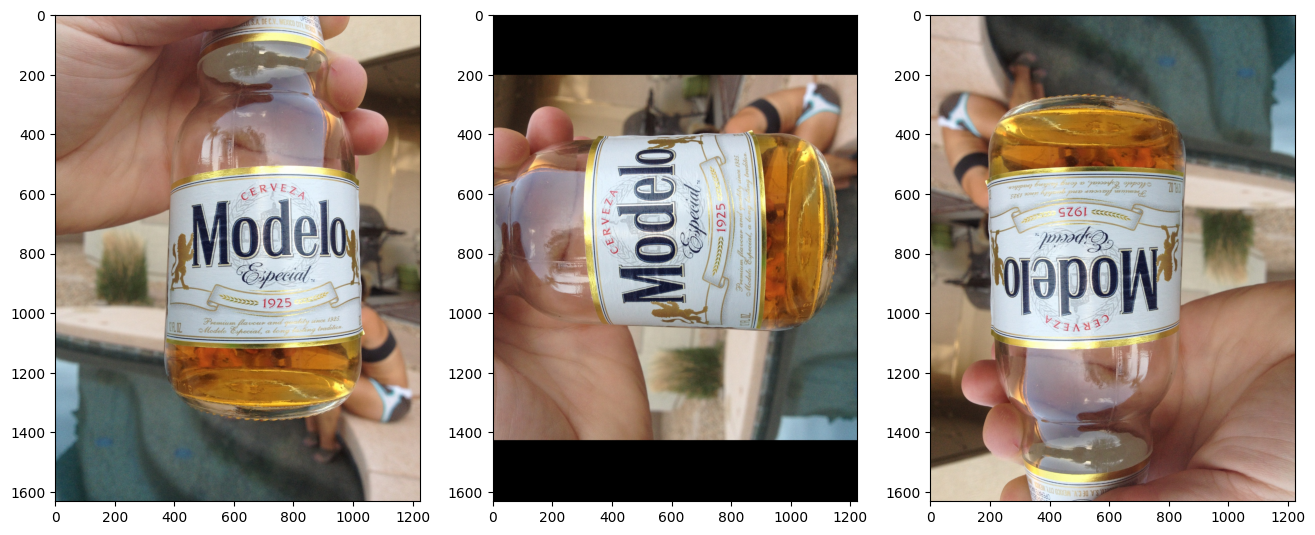

In [26]:
# set-up a plot to show the images
rcParams["figure.figsize"] = 16, 8
fig, ax = plt.subplots(1, 3)
plt_counter = 0

# show original image
pillow_image = Image.open(dataset_to_caption[4]["image_filepath"])
ax[plt_counter].imshow(pillow_image)
plt_counter += 1

# apply varying levels of defocus
rotation_settings = [90, 180]
image_np = np.array(pillow_image)
for setting in rotation_settings:
    rotation_transform = A.Rotate(limit=(setting, setting), p=1.0)
    rotation_result_np = rotation_transform(image=image_np)["image"]
    rotation_result_pil = Image.fromarray(np.uint8(rotation_result_np)).convert("RGB")
    ax[plt_counter].imshow(rotation_result_pil)
    plt_counter += 1

In [27]:
for index, row in enumerate(tqdm(dataset_to_caption)):
    # get image and load it
    curr_image = row["image_filepath"]
    curr_pillow_image = Image.open(curr_image)
    curr_image_np = np.array(curr_pillow_image)

    # generate output for clean image and store in dict
    dataset_to_caption[index]["original_image_caption"] = generate_caption(
        curr_pillow_image,
        model,
        processor,
        prompt,
        temperature=1.0,
        do_sample=False,
    )

    # rotate image 90 degrees and 180 degrees
    for label, rotation_setting in [
        ("rotation_90_image_caption", 90),
        ("rotation_180_image_caption", 180),
    ]:
        rotation_transform = A.Rotate(limit=(rotation_setting, rotation_setting), p=1.0)
        rotation_result_np = rotation_transform(image=curr_image_np)["image"]
        rotation_result_pil = Image.fromarray(np.uint8(rotation_result_np)).convert(
            "RGB"
        )

        # generate output for each rotated image and store in dict
        dataset_to_caption[index][label] = generate_caption(
            rotation_result_pil,
            model,
            processor,
            prompt,
            temperature=1.0,
            do_sample=False,
        )

  0%|          | 0/12 [00:00<?, ?it/s]

In [28]:
# create a dataframe
output_df = pd.DataFrame.from_dict(dataset_to_caption)

# sort on image type and name
output_df.sort_values(by=["type", "name"], inplace=True)

# save file
output_df.to_csv(
    "../data/labeled-data/molmo-model/rotated_image_experiment_03-03-25.csv",
    index=False,
)

# print dataframe
output_df.head()

,name,type,image_filepath,original_image_caption,rotation_90_image_caption,rotation_180_image_caption,"notes (include initials, e.g. 'KG: ...')"
11,VizWiz_train_00000050,heavy text images,../data/rotation-experiment-images/heavy-text-...,A hand holds a Dr. Oetker Onken yogurt contain...,"A hand holds a blue container labeled ""Dr. Oet...",A hand holds a blue and white container labele...,
9,VizWiz_train_00000165,heavy text images,../data/rotation-experiment-images/heavy-text-...,A box of pre-portioned double chocolate browni...,A box of gourmet double chocolate brownie cook...,The image shows a box of Godiva chocolate with...,
10,VizWiz_train_00000323,heavy text images,../data/rotation-experiment-images/heavy-text-...,The image shows a list of Christian songs on a...,The image shows a sideways view of a CD case w...,The image shows a menu for a restaurant or bar...,
8,VizWiz_train_00000339,heavy text images,../data/rotation-experiment-images/heavy-text-...,"A torn box with drug facts and warnings, likel...",A box with blue and red text on a white surfac...,A box with blue and red text on a white surfac...,
1,VizWiz_train_00000012,light text images,../data/rotation-experiment-images/light-text-...,A person's hand holds a JVC DVD and VCR remote...,A person's hands are holding a remote control ...,"A person's hands holding a large, upside-down ...",
